# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools

import warnings
warnings.filterwarnings('ignore')

sns.set_style()

In [7]:
data = pd.read_csv('Border_Crossing_Entry_Data.csv', index_col=[4])

# Data Info

In [8]:
len(data)

355511

In [9]:
data.head()

,Port Name,State,Port Code,Border,Measure,Value
Date,,,,,,
2/1/2020 00:00,Alcan,AK,3104,US-Canada Border,Personal Vehicle Passengers,1414
2/1/2020 00:00,Alcan,AK,3104,US-Canada Border,Personal Vehicles,763
2/1/2020 00:00,Alcan,AK,3104,US-Canada Border,Truck Containers Empty,412
2/1/2020 00:00,Alcan,AK,3104,US-Canada Border,Truck Containers Full,122
2/1/2020 00:00,Alcan,AK,3104,US-Canada Border,Trucks,545


In [10]:
data.describe()

,Port Code,Value
count,355511.000000,3.555110e+05
mean,2454.009921,2.844758e+04
std,1201.900231,1.518807e+05
min,101.000000,0.000000e+00
25%,2304.000000,0.000000e+00
50%,3013.000000,1.000000e+02
75%,3402.000000,2.597500e+03
max,4105.000000,4.447374e+06


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355511 entries, 2/1/2020 00:00 to 1/1/1996 00:00
Data columns (total 6 columns):
Port Name    355511 non-null object
State        355511 non-null object
Port Code    355511 non-null int64
Border       355511 non-null object
Measure      355511 non-null object
Value        355511 non-null int64
dtypes: int64(2), object(4)
memory usage: 19.0+ MB


# Visualize Raw Data

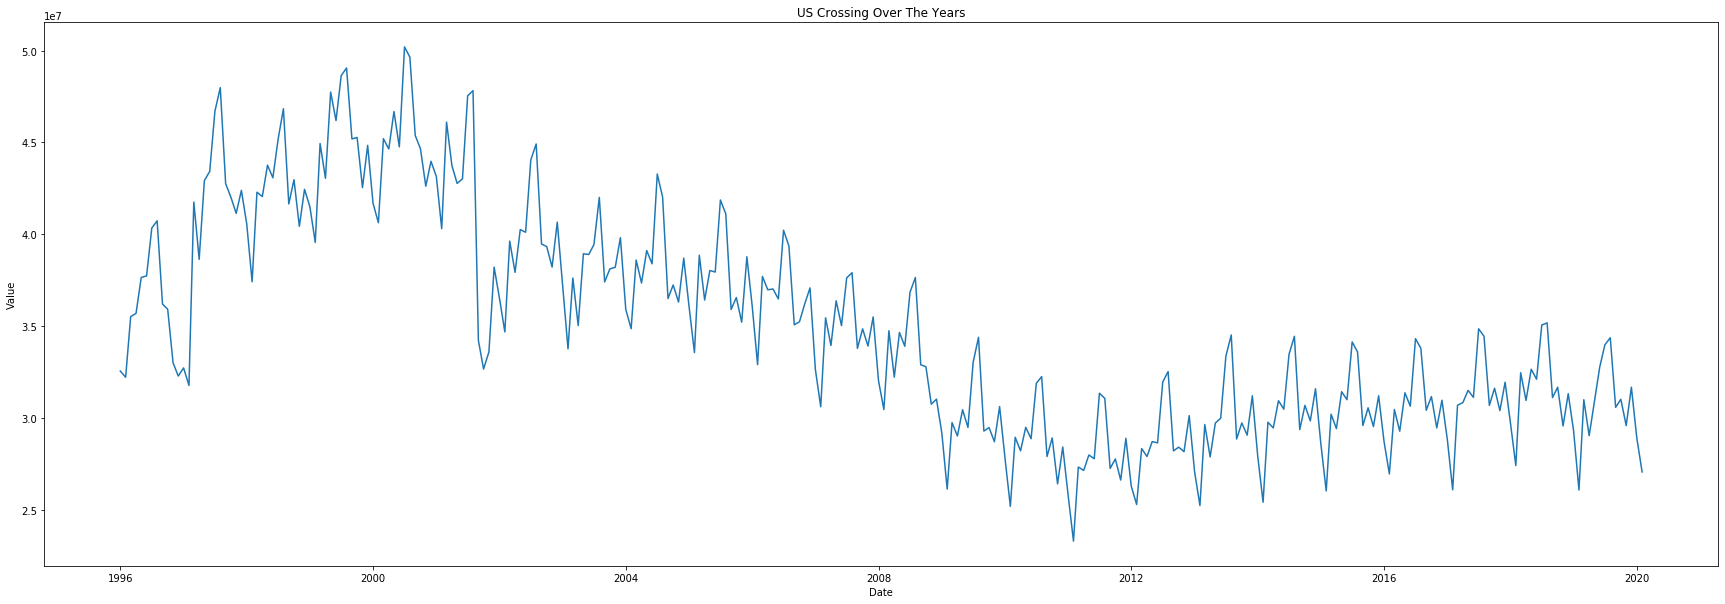

In [14]:
plt.figure(figsize=(30,10))
plt.title('US Crossing Over The Years')
sns.lineplot(data['Date'], data['Value'], estimator='sum', ci=None);

In [28]:
def plot_dec(data, col, kind):
    
    tseries = data.groupby(['Date'])[col].agg(
        [kind]).reset_index().rename(columns={kind: col})
    tseries = tseries.set_index('Date')

    decompose = seasonal_decompose(
        tseries, model='additive', extrapolate_trend='freq')

    fig, axes = plt.subplots(nrows=4, figsize=(16, 8))

    decompose.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')

    decompose.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')

    decompose.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')

    decompose.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

    plt.tight_layout()
    plt.show()


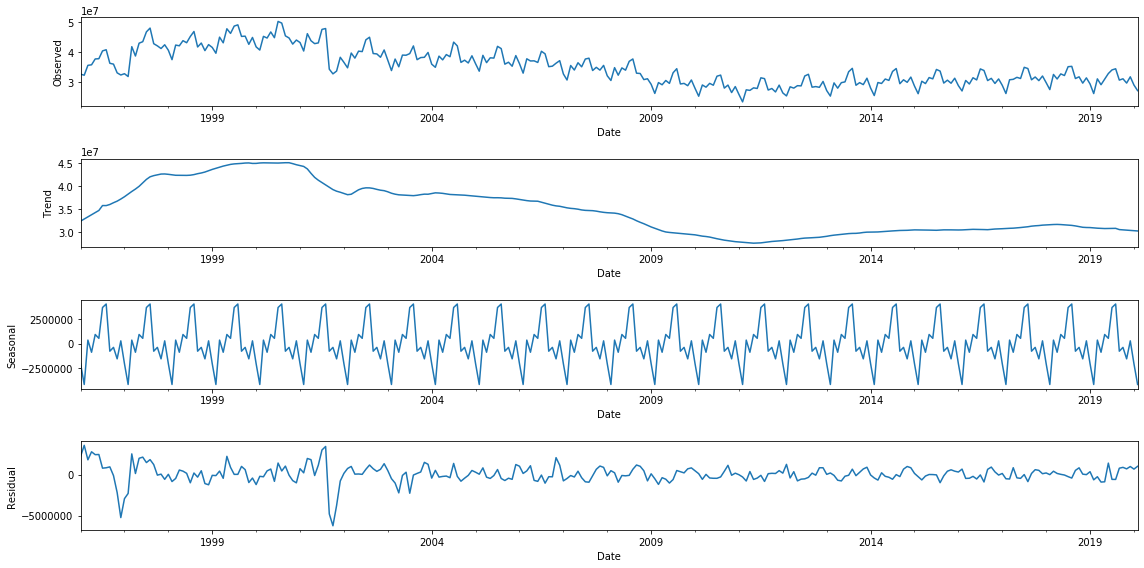

In [29]:
plot_dec(data, 'Value', 'sum')

# Feature Eng

### Date

In [13]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.weekday

In [14]:
data.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,year,month,day,day_of_week
0,Alcan,AK,3104,US-Canada Border,2020-02-01,Personal Vehicle Passengers,1414,2020,2,1,5
1,Alcan,AK,3104,US-Canada Border,2020-02-01,Personal Vehicles,763,2020,2,1,5
2,Alcan,AK,3104,US-Canada Border,2020-02-01,Truck Containers Empty,412,2020,2,1,5
3,Alcan,AK,3104,US-Canada Border,2020-02-01,Truck Containers Full,122,2020,2,1,5
4,Alcan,AK,3104,US-Canada Border,2020-02-01,Trucks,545,2020,2,1,5


In [15]:
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if (x==5 or x==6) else 0)

In [16]:
data.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,year,month,day,day_of_week,is_weekend
0,Alcan,AK,3104,US-Canada Border,2020-02-01,Personal Vehicle Passengers,1414,2020,2,1,5,1
1,Alcan,AK,3104,US-Canada Border,2020-02-01,Personal Vehicles,763,2020,2,1,5,1
2,Alcan,AK,3104,US-Canada Border,2020-02-01,Truck Containers Empty,412,2020,2,1,5,1
3,Alcan,AK,3104,US-Canada Border,2020-02-01,Truck Containers Full,122,2020,2,1,5,1
4,Alcan,AK,3104,US-Canada Border,2020-02-01,Trucks,545,2020,2,1,5,1


# EDA

## The Data Seens To Follow a Trend, Lets See It

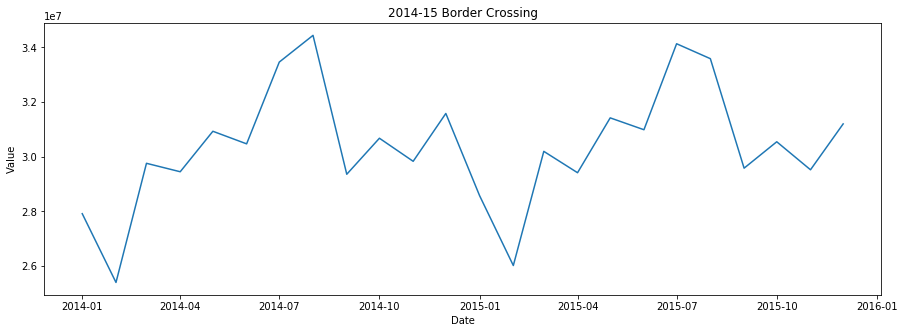

In [17]:
data_2000 = data[(data['year']==2014) | (data['year']==2015)]

plt.figure(figsize=(15,5))
plt.title('2014-15 Border Crossing')
sns.lineplot(data_2000['Date'], data_2000['Value'], estimator='sum', ci=None);

Apparently most people visit the US during the summer

## Canada and Mexico Comparision

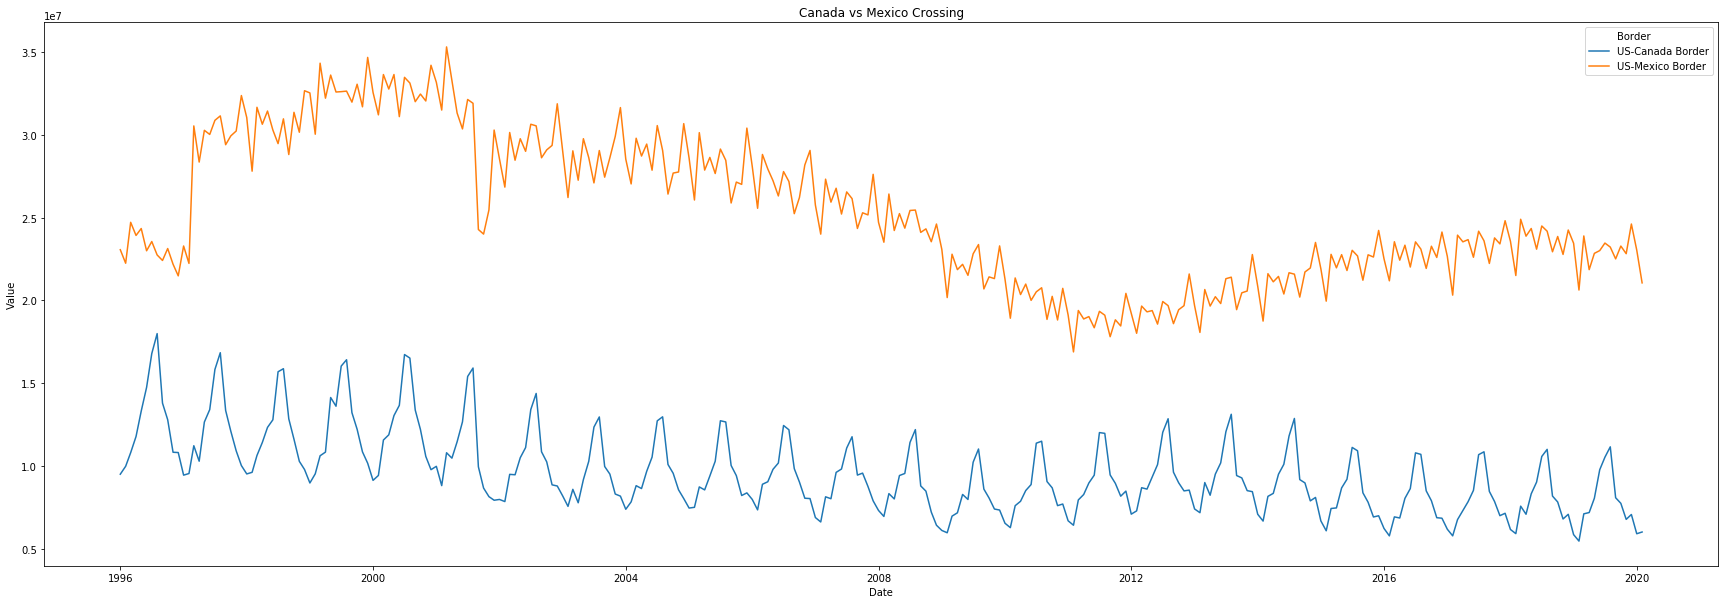

In [18]:
plt.figure(figsize=(30,10))
plt.title('Canada vs Mexico Crossing')
sns.lineplot(data=data, x ='Date', y='Value', estimator='sum', ci=None, hue='Border');

Hum, BIG DIFFERENCES


### Canada vs Mexico Trend

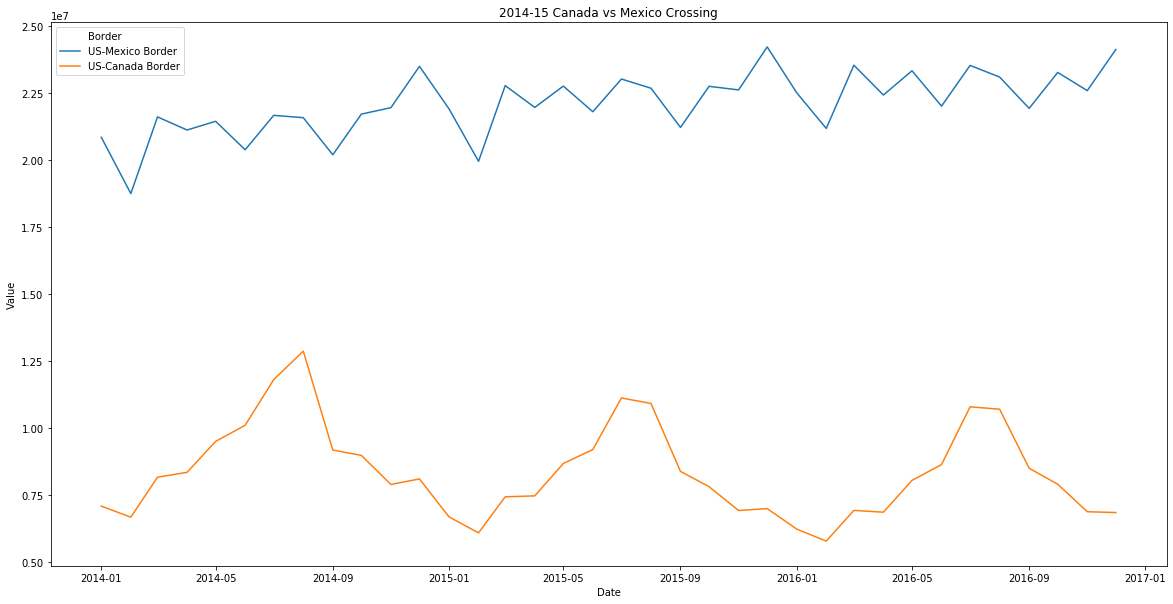

In [19]:
data_2000 = data[(data['year']==2014) | (data['year']==2015) | (data['year']==2016)]

plt.figure(figsize=(20,10))
plt.title('2014-15 Canada vs Mexico Crossing')
sns.lineplot(data=data_2000, x ='Date', y='Value', estimator='sum', ci=None, hue='Border');

Its seens like Mexicans tends to visit US in the end od the year, and Canadians in the summer

## Weekend Analysis

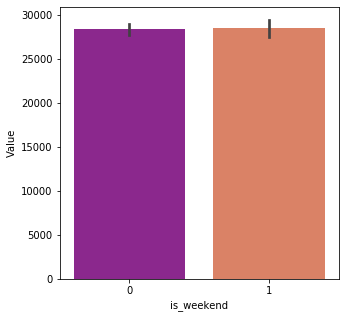

In [20]:
plt.figure(figsize=(5,5))
sns.barplot(data=data, x='is_weekend', y='Value', palette='plasma');

Not Much Difference

## Month

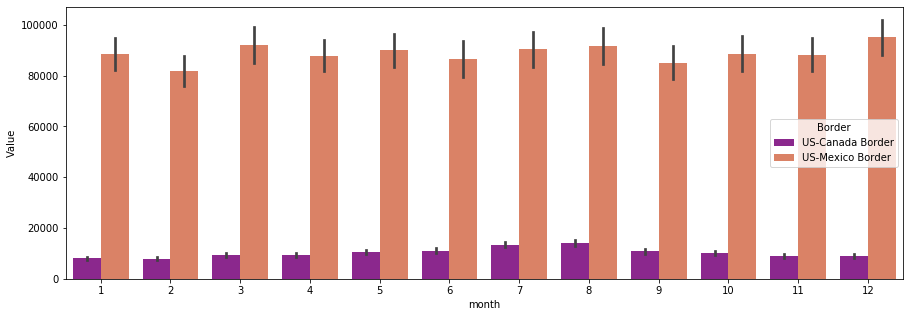

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(data=data, x='month', y='Value', hue='Border', palette='plasma');

In [22]:
data.groupby('month').agg({'Value':sum}).sort_values('Value', ascending=False)

,Value
month,
8,937502593
7,929203169
5,860938239
6,851723533
3,846878573
12,843563587
10,828529588
9,819571450
4,816709488


## States

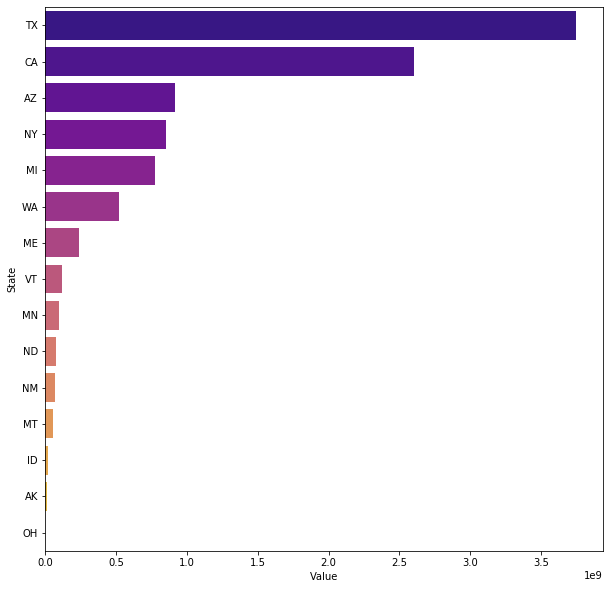

In [23]:
g = data.groupby('State').agg({'Value':sum}).sort_values('Value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(x=g['Value'], y=g.index, palette='plasma');

### Mexico

In [24]:
data[data['Border']=='US-Mexico Border'].groupby('State').agg({'Value':'mean'}).sort_values(by='Value', ascending=False)

,Value
State,
CA,133103.511993
TX,101960.920861
AZ,46502.652504
NM,10364.373696


### Canada

In [25]:
data[data['Border']=='US-Canada Border'].groupby('State').agg({'Value':'mean'}).sort_values(by='Value', ascending=False)

,Value
State,
MI,74759.961531
NY,40052.647329
WA,11375.292587
VT,7061.449632
ME,6054.553135
MN,4183.808931
ID,3228.836143
MT,1442.061033
ND,1348.446800


## Type of Vehicle

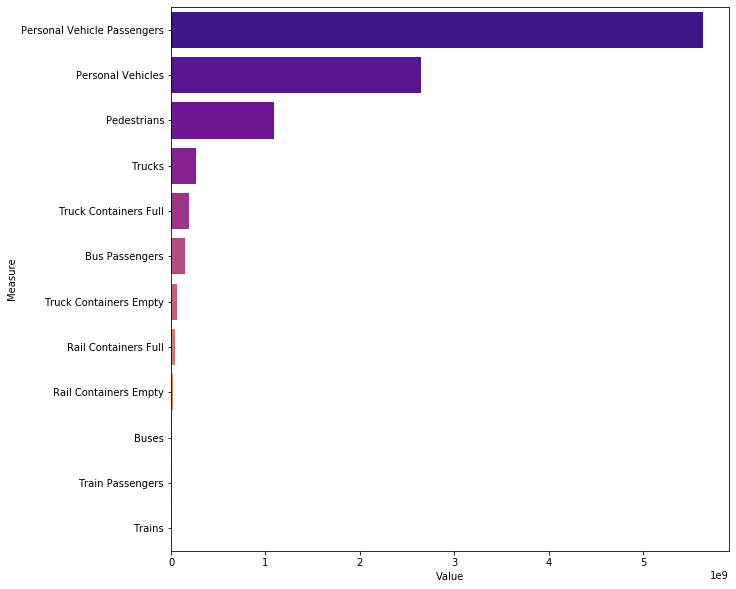

In [26]:
g = data.groupby('Measure').agg({'Value':sum}).sort_values('Value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(x=g['Value'], y=g.index, palette='plasma');

## Port Name

In [27]:
g = data.groupby('Port Name').agg({'Value':sum, 'Port Name':'count'})
g.index.name = None
g.sort_values(by='Value', ascending=False)

,Value,Port Name
El Paso,1186748989,3478
San Ysidro,1184198982,3179
Laredo,676914805,3437
Hidalgo,583725539,3308
Buffalo-Niagara Falls,559736205,3480
...,...,...
Willow Creek,150005,1751
Algonac,121107,33
Boquillas,71870,261
Whitlash,68987,3117


# Model 2010-2019

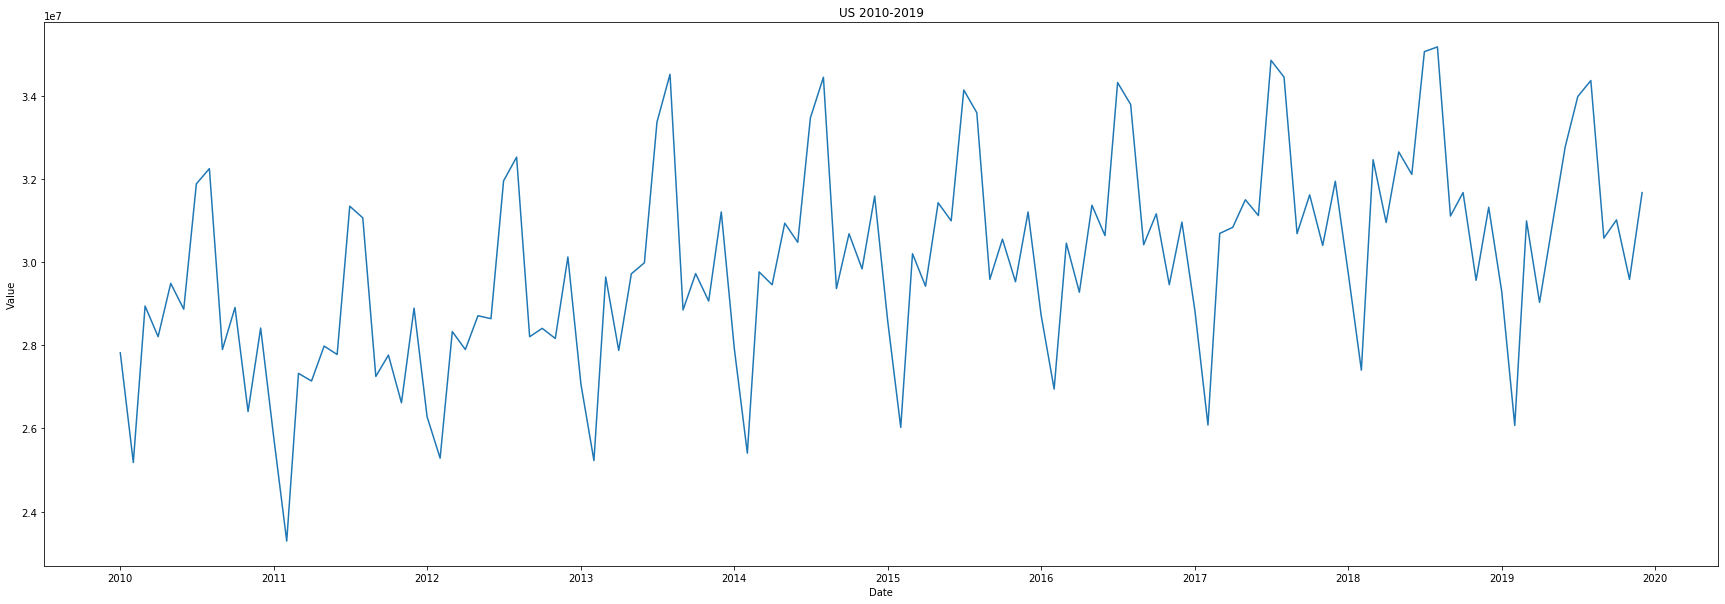

In [28]:
data_new = data[(data['year']>=2010) & (data['year']<2020)]

plt.figure(figsize=(30,10))
plt.title('US 2010-2019')
sns.lineplot(data_new['Date'], data_new['Value'], estimator='sum', ci=None);

In [29]:
len(data_new)

138142

### Decompose

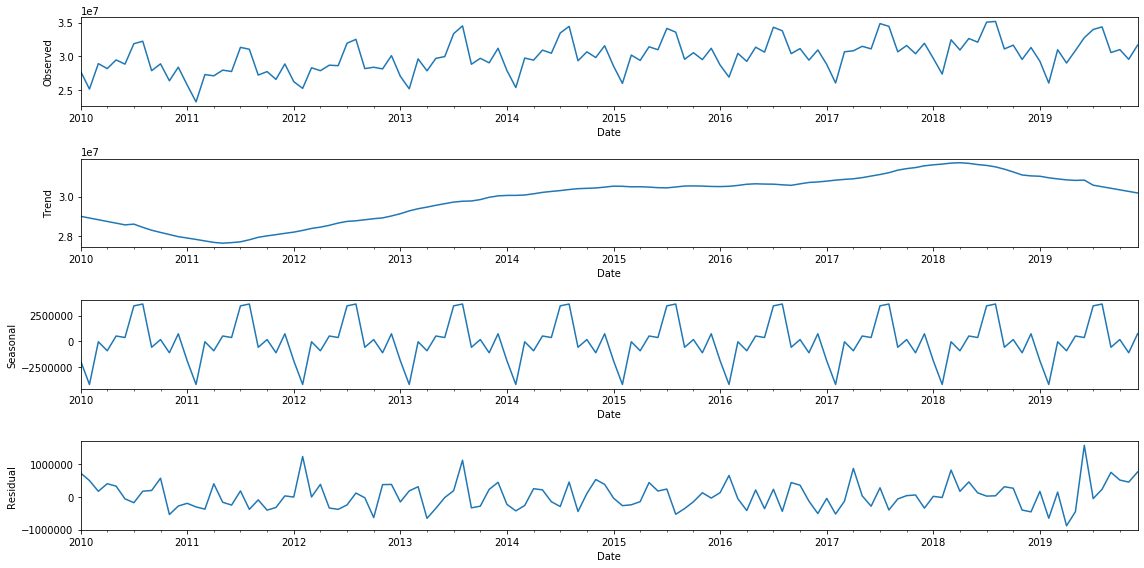

In [30]:
plot_dec(data_new, 'Value', 'sum')

## Arima

### Funtion To Test ARIMAS

In [31]:
def find_best_sarima(train, eval_metric, order):
    
    p = d = q = range(0, order)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [33]:
tseries = data_new.groupby(['Date'])['Value'].agg(
        ['sum']).reset_index().rename(columns={'sum': 'Value'})
tseries = tseries.set_index('Date')

train, test = tseries.iloc[:100], tseries.iloc[100:]

best = find_best_sarima(train, 'aic', 2)
best

{'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x17b30baf588>,
 'aic': 2141.516462061919,
 'bic': 2148.387840385364,
 'order': (0, 1, 1),
 'seasonal_order': (0, 1, 1, 12)}

## Auto ARIMA

In [36]:
from pmdarima.arima import auto_arima

In [42]:
model = auto_arima(tseries, start_p=0, start_q=0, max_p=6, max_q=6, start_P=0,
                  m=12, seasonal=True, d=1, D=1, trace=True,
                  error_action='ignore', supress_warnings=True, stepwise=True)
model.aic()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=3189.922, BIC=3197.941, Time=0.152 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=3188.275, BIC=3193.621, Time=0.015 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=3191.905, BIC=3202.596, Time=0.163 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=3192.685, BIC=3203.376, Time=0.181 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=3187.113, BIC=3189.786, Time=0.013 seconds
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=3189.931, BIC=3197.950, Time=0.097 seconds
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=3191.399, BIC=3202.090, Time=0.364 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=3190.258, BIC=3198.277, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=3191.067, BIC=3199.085, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=3192.811, BIC=3203.503, Time=0.187 seconds
Total fit time: 1.268 seco

3187.1132516423795

In [43]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

# Model Comparision

In [111]:
pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

pred2 = model.predict(n_periods=20)
pred2 = pd.DataFrame(pred, index=test.index, columns=['Values'])

In [112]:
p1 = pd.DataFrame({'Real':np.squeeze(np.asarray(test.values)), 'Pred':pred.values})

In [113]:
p2 = pd.DataFrame({'Real':np.squeeze(np.asarray(test.values)), 'Pred':np.squeeze(np.asarray(pred2.values))})

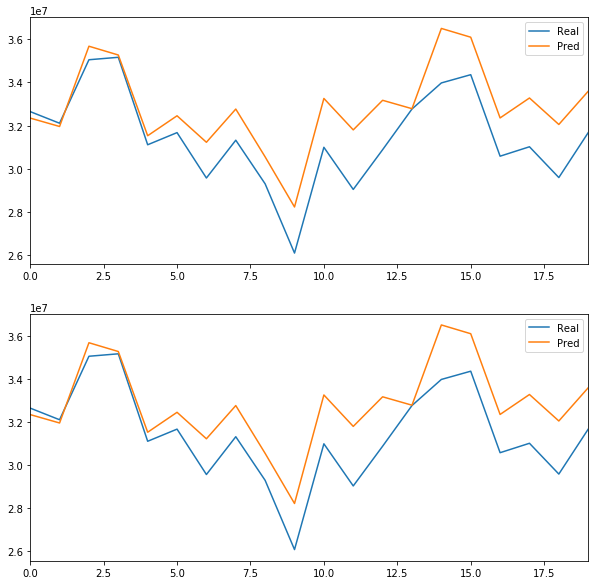

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
p1.plot(ax=axes[0])
p2.plot(ax=axes[1]);